In [1]:
import pandas as pd
#pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

import re
#from numpy import triu
#from scipy.linalg import triu
from gensim.models import Word2Vec
#import openai
from sklearn.svm import SVC
#from secret_key import openai_key
from sentence_transformers import SentenceTransformer
import spacy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsta0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\dsta0\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##df_tweets = pd.read_csv('training.1600000.processed.noemoticon.csv', 
#df_tweets = pd.read_csv('balanced.csv', 
# df_tweets = pd.read_csv('balanced_sentiment_dataset_100k.csv', 
#                     encoding='latin-1',  names=['target','ids','date','flag','user','text'])

df_tweets = pd.read_csv('balanced_sentiment_dataset_100k.csv', 
                    encoding='latin-1')

In [37]:
df_tweets.sample(10)

,target,ids,date,flag,user,text
80635,0,2067588480,Sun Jun 07 12:36:40 PDT 2009,NO_QUERY,knunn,forgot to checkin at 11:15 - http://bkite.co...
46195,0,2201323585,Tue Jun 16 20:06:57 PDT 2009,NO_QUERY,Kelndan,I WANT A DSi sooooooomone..........why cant i ...
32206,1,2015098343,Wed Jun 03 03:41:40 PDT 2009,NO_QUERY,WParenthetical,&quot;If a triangle could speak it would say t...
18652,1,2180956090,Mon Jun 15 11:10:11 PDT 2009,NO_QUERY,Thewie72,@ninaoo7 use #captions I copied it so I can p...
57037,1,1881000762,Fri May 22 03:15:13 PDT 2009,NO_QUERY,LesleySmith,@louisebolotin I need me one of those
94104,1,1833565154,Sun May 17 23:42:00 PDT 2009,NO_QUERY,charliechap,"@MsKae Sleep well, and don't forget to air out..."
54644,0,2286970675,Mon Jun 22 17:10:30 PDT 2009,NO_QUERY,bethanycamille,Sad! I Got blue contacts and you can not even ...
69510,1,2065942091,Sun Jun 07 09:35:21 PDT 2009,NO_QUERY,ReneeDeLuca,@MelissaEGilbert Will have to read your book--...
67635,1,1685888650,Sun May 03 02:36:55 PDT 2009,NO_QUERY,daanwesterink,My brother is coming over. Nothing else matters
6603,0,2262977193,Sat Jun 20 23:39:52 PDT 2009,NO_QUERY,JuLars,I am pissed my sleep pattern is so off I miss...


In [38]:
df_tweets = df_tweets[['target', 'text']]

# Basic Preprocessing

In [5]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, and special chars
    text = re.sub(r'http\S+|@\w+|[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords/stem
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_tweets['cleaned_text'] = df_tweets['text'].apply(preprocess)

In [ ]:
# df_tweets['target'] = df_tweets['target'].replace(4, 1)

In [7]:
df_tweets.to_csv('sample_tweets_cleaned.csv', encoding='utf-8', index=False)

# Preprocessing

Handle the missing values

In [40]:
missing_percentage = df_tweets.isna().sum()
print(missing_percentage)

target    0
text      0
dtype: int64


In [41]:
df_tweets['lowercase'] = df_tweets['text'].str.lower()

In [50]:
def remove_special_characters(text):
    return re.sub(r'[^a-z\s]', '', text)

df_tweets['cleaned'] = df_tweets['lowercase'].apply(remove_special_characters)

In [48]:
# Load the SpaCy language model
nlp = spacy.load("en_core_web_sm")  # Make sure it's installed

In [51]:
def remove_stopwords(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

df_tweets['no_stopwords'] = df_tweets['cleaned'].apply(remove_stopwords)

In [52]:
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

df_tweets['lemmatized'] = df_tweets['no_stopwords'].apply(lemmatize_tokens)

In [53]:
def clean_hashtags(tokens):
    return [token[1:] if token.startswith('#') else token for token in tokens]

df_tweets['cleaned_hashtags'] = df_tweets['lemmatized'].apply(clean_hashtags)

In [54]:
import re

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)

def remove_emojis(tokens):
    return [emoji_pattern.sub(r'', token) for token in tokens if not emoji_pattern.match(token)]

df_tweets['no_emojis'] = df_tweets['cleaned_hashtags'].apply(remove_emojis)

In [55]:
df_tweets.to_csv('100k_tweets_preprocessed.csv', encoding='utf-8', index=False)

# Feature representation

In [3]:
df_tweets_cleaned = pd.read_csv("100k_tweets_preprocessed.csv")

In [4]:
df_tweets_cleaned = df_tweets_cleaned[['target', 'no_emojis']]

df_tweets_cleaned.sample(5)

,target,no_emojis
93904,1,"['ve', 'slay', 'awesome', 'day', 'turn', 'horr..."
72705,1,"['miss', 'home', 'entail', 'get', 'bite', 'm',..."
84362,1,"['karenmorris', 'act', 'revenge', ' ', 'packe..."
58060,0,"['redantique', 'berry']"
15985,0,"['cosmicfavorite', 'not', 'tix', 'bcos', 'scho..."


In [ ]:
# df_tweets_cleaned['cleaned_text'] = df_tweets_cleaned['cleaned_text'].fillna('tree').astype(str)

In [5]:
X = df_tweets_cleaned['no_emojis']
y = df_tweets_cleaned['target']

X_train_tf_idf, X_test_tf_idf, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train_tf_idf.shape, X_test_tf_idf.shape, y_train.shape, y_test.shape

((80000,), (20000,), (80000,), (20000,))

In [ ]:
#X_train = X_train.fillna("")
#X_test = X_test.fillna("")

## TF-IDF

In [6]:
featurizer = TfidfVectorizer()

X_train_tf_idf = featurizer.fit_transform(X_train_tf_idf)
X_test_tf_idf  = featurizer.transform(X_test_tf_idf)

In [7]:
X_train_tf_idf

<80000x84479 sparse matrix of type '<class 'numpy.float64'>'
	with 523356 stored elements in Compressed Sparse Row format>

In [8]:
print(X_train_tf_idf.shape)

(80000, 84479)


## Word2Vec

In [9]:
# Tokenize for Word2Vec
sentences = [text.split() for text in df_tweets_cleaned['no_emojis']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Document embedding (average word vectors)
def document_vector(text):
    words = text.split()
    return np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv], axis=0)
    '''
    word_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    
    return np.mean(word_vecs, axis=0)
    '''

X_w2v = np.array([document_vector(text) for text in df_tweets_cleaned['no_emojis']])

In [10]:
X_w2v

array([[-0.21451741,  0.7712062 ,  0.9355609 , ..., -0.4799122 ,
         0.32392016,  0.19655745],
       [-0.55144197,  0.8890793 ,  1.2280077 , ..., -0.7872181 ,
         0.40831363,  0.41418412],
       [-0.4080828 ,  0.2792511 ,  0.2639627 , ..., -0.3245104 ,
        -0.19296642, -0.08805261],
       ...,
       [-0.3452593 ,  0.6994606 ,  0.87642896, ..., -0.6982056 ,
         0.27904892,  0.09381237],
       [-0.58802587,  0.6229226 ,  0.3892293 , ..., -0.6282721 ,
         0.23110227, -0.16153835],
       [-0.50042534,  0.78567564,  0.79054004, ..., -0.6492147 ,
         0.27121976,  0.18125607]], dtype=float32)

In [11]:
print(X_w2v.shape)

(100000, 100)


In [ ]:
#pd.Series(df_tweets_cleaned['cleaned_text']).isna().sum()

0

In [12]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=123)

X_train_w2v.shape, X_test_w2v.shape, y_train.shape, y_test.shape

((80000, 100), (20000, 100), (80000,), (20000,))

## BERT

In [ ]:
#openai.api_key = openai_key

In [1]:
# Use OpenAI's API (requires API key)
# def get_gpt_embedding(text):
# response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
# return np.array(response['data'][0]['embedding'])

# X_gpt = np.array([get_gpt_embedding(text) for text in df_tweets_cleaned['cleaned_text']])

In [13]:
# Load a lightweight BERT-based model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and great for embeddings

# Ensure cleaned text is a list of strings
texts = df_tweets_cleaned['no_emojis'].fillna('').astype(str).tolist()

# Generate embeddings
X_bert = model.encode(texts, show_progress_bar=True)

Batches: 100%|██████████| 3125/3125 [05:18<00:00,  9.81it/s]


In [14]:
X_bert

array([[-0.04485021, -0.04264412, -0.00525744, ..., -0.00553362,
        -0.00602297,  0.02970693],
       [-0.02060345,  0.03405784, -0.02794828, ...,  0.11837119,
         0.03944125, -0.02530853],
       [ 0.04897955, -0.03182269,  0.03071005, ...,  0.05528144,
         0.01947791, -0.0520927 ],
       ...,
       [-0.04037578, -0.07581542, -0.02984781, ...,  0.07661375,
         0.00486614,  0.03132267],
       [-0.018034  ,  0.00310953,  0.03367927, ...,  0.05459262,
         0.02036844,  0.05526228],
       [-0.03944533, -0.09184176, -0.01866939, ...,  0.0556329 ,
        -0.00763105,  0.0256989 ]], dtype=float32)

In [15]:
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=123)

X_train_bert.shape, X_test_bert.shape, y_train.shape, y_test.shape

((80000, 384), (20000, 384), (80000,), (20000,))

# Classification

In [16]:
# Training 
svm_td_idf = SVC(kernel='rbf')

# TF-IDF
svm_td_idf.fit(X_train_tf_idf, y_train)
y_pred_tfidf = svm_td_idf.predict(X_test_tf_idf)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))




TF-IDF Accuracy: 0.7615


In [17]:
# Training 
svm_w2v = SVC(kernel='rbf')

# Word2Vec
svm_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = svm_w2v.predict(X_test_w2v)
print("Word2Vec Accuracy:", accuracy_score(y_test, y_pred_w2v))

Word2Vec Accuracy: 0.6676


In [18]:
# Training 
svm_bert = SVC(kernel='rbf')

# BERT embedding
svm_bert.fit(X_train_bert, y_train)
y_pred_bert = svm_bert.predict(X_test_bert)
print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))

BERT Accuracy: 0.7511


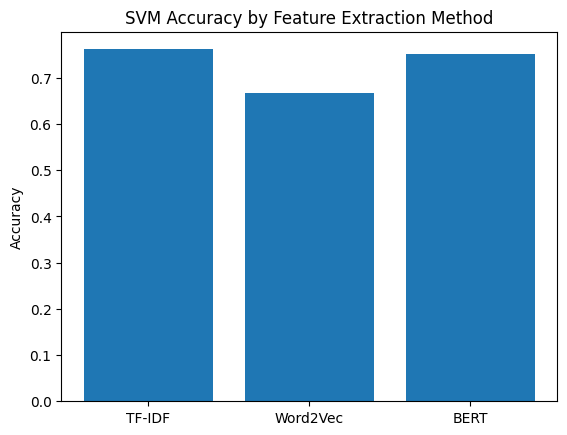

In [19]:
accuracies = {
    'TF-IDF': accuracy_score(y_test, y_pred_tfidf),
    'Word2Vec': accuracy_score(y_test, y_pred_w2v),
    'BERT': accuracy_score(y_test, y_pred_bert)
}

plt.bar(accuracies.keys(), accuracies.values())
plt.title('SVM Accuracy by Feature Extraction Method')
plt.ylabel('Accuracy')
plt.show()

In [20]:
# Evaluating TF-IDF
print(confusion_matrix(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

[[7451 2485]
 [2285 7779]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      9936
           1       0.76      0.77      0.77     10064

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [21]:
# Evaluating Word2Vec
print(confusion_matrix(y_test, y_pred_w2v))
print(classification_report(y_test, y_pred_w2v))

[[6440 3496]
 [3152 6912]]
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      9936
           1       0.66      0.69      0.68     10064

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000



In [22]:
# Evaluating BERT
print(confusion_matrix(y_test, y_pred_bert))
print(classification_report(y_test, y_pred_bert))

[[7261 2675]
 [2303 7761]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      9936
           1       0.74      0.77      0.76     10064

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [25]:
# Classification using DNN
model = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),  # Input dim = 100 (Word2Vec vec size)
    Dropout(0.5),  # Regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output (0=Negative, 1=Positive)
])
# model = Sequential([
#     # Input layer (100-dim Word2Vec vectors)
#     Dense(256, activation='relu', input_shape=(100,), kernel_regularizer=l2(0.01)),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     # Hidden layers
#     Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
#     BatchNormalization(),
#     Dropout(0.4),
    
#     Dense(64, activation='relu'),
#     Dropout(0.3),
    
#     # Output layer
#     Dense(1, activation='sigmoid')
# ])


model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               12928     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(
    X_train_w2v, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_w2v, y_test)
)

Epoch 1/30
2500/2500 [==============================] - 10s 3ms/step - loss: 0.6387 - accuracy: 0.6255 - val_loss: 0.6197 - val_accuracy: 0.6478
Epoch 2/30
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6266 - accuracy: 0.6421 - val_loss: 0.6193 - val_accuracy: 0.6592
Epoch 3/30
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6218 - accuracy: 0.6483 - val_loss: 0.6122 - val_accuracy: 0.6578
Epoch 4/30
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6191 - accuracy: 0.6524 - val_loss: 0.6141 - val_accuracy: 0.6558
Epoch 5/30
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6172 - accuracy: 0.6540 - val_loss: 0.6122 - val_accuracy: 0.6611
Epoch 6/30
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6158 - accuracy: 0.6542 - val_loss: 0.6093 - val_accuracy: 0.6631
Epoch 7/30
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6143 - accuracy: 0.6560 - val_loss: 0.6081 - val_accuracy

In [26]:
print(f"X_train_w2v shape: {X_train_w2v.shape}")  # Should be (n_samples, 100)
print(f"y_train shape: {y_train.shape}")  # Should be (n_samples,) or (n_samples, 1)

X_train_w2v shape: (35000, 100)
y_train shape: (35000,)


In [ ]:
# from tensorflow.keras import backend as K
# K.clear_session()